In [18]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from tqdm import tqdm
from src.cdr_bench.io_utils.io import read_features_hdf5_dataframe
from src.cdr_bench.features.physchem import calculate_descriptors
from src.cdr_bench.features.feature_preprocessing import find_nonconstant_features
from src.cdr_bench.scoring.scoring import tanimoto_int_similarity_matrix_numba, euclidean_distance_square_numba
from src.cdr_bench.scoring.network_stat import generate_networks_for_thresholds, calculate_network_metrics
from src.cdr_bench.scoring.scaffold_stat import calculate_scaffold_frequencies_and_f50
from src.cdr_bench.scoring.chemsim_stat import calculate_similarity_statistics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Calculate diversity in the datasets and perform scaffold analysis

## Set up a path to the datasets

In [112]:
#path_2_datasets = Path('../datasets/')
path_2_datasets = Path('/home/aorlov/PycharmProjects/cdr_bench/data/data_upd/wide_range_upd230724/')
#path_2_datasets = Path('/home/aorlov/PycharmProjects/cdr_bench/data/data_upd/chembl_random/')

## Set up some threshold values used for calculations

In [113]:
similarity_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

## Iterate over a directory to get the results

In [114]:
network_analysis_ls = []
chemdiv_analysis_ls = []

In [115]:
for dataset in tqdm(path_2_datasets.glob('*.h5')):
    # Read and preprocess the data
    df_features = read_features_hdf5_dataframe(dataset)
    df_features.reset_index(inplace=True)
    df_features.rename(columns={'index': 'cid'}, inplace=True)
    dataset_name = dataset.stem

    # Prepare molecule and scaffold data
    df_features['mol'] = df_features['smi'].parallel_apply(lambda x: Chem.MolFromSmiles(x))
    df_features['scaffold'] = df_features['mol'].parallel_apply(lambda x: Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(x)))
  
    # Calculate physicochemical descriptors and diversity
    physchem_descriptors = np.vstack(df_features['mol'].parallel_apply(lambda x: calculate_descriptors(x)).values)
    non_constant_indices = find_nonconstant_features(physchem_descriptors)
    physchem_descriptors =  physchem_descriptors[:, non_constant_indices]
    physchem_descriptors =  np.unique(physchem_descriptors, axis=0)
    intra_dataset_distances = euclidean_distance_square_numba(physchem_descriptors, physchem_descriptors)
    physchem_sim = calculate_similarity_statistics(intra_dataset_distances)
    physchem_sim_prefixed = {f"{key}_physchem": value for key, value in physchem_sim.items()}

    # Calculate scaffold frequencies and F50
    f50 = calculate_scaffold_frequencies_and_f50(df_features['scaffold'].tolist())

    # Initialize chemdiv_df with dataset name and F50 metric
    chemdiv_df = pd.DataFrame({'Dataset': [dataset_name], 'F50': [f50]})
    chemdiv_df = chemdiv_df.assign(**physchem_sim_prefixed)

    # Process Morgan and MACCS descriptors
    for desc in ['mfp_r2_1024', 'maccs_keys']:
        fingerprints = np.vstack(df_features[desc].tolist()).astype(np.float64)
        non_constant_indices = find_nonconstant_features(fingerprints)
        fingerprints =  fingerprints[:, non_constant_indices]
        fingerprints =  np.unique(fingerprints, axis=0)
        # Calculate similarity matrix and statistics
        sim_mat = tanimoto_int_similarity_matrix_numba(fingerprints, fingerprints)
        similarity_stats = calculate_similarity_statistics(sim_mat)
        similarity_stats_prefixed = {f"{key}_{desc}": value for key, value in similarity_stats.items()}

        # Update chemdiv_df with similarity statistics for current descriptor
        chemdiv_df = chemdiv_df.assign(**similarity_stats_prefixed)

        # Generate networks and calculate metrics for each threshold
        networks = generate_networks_for_thresholds(sim_mat, df_features["cid"].tolist(), similarity_thresholds)
        network_metrics_ls = []
        for threshold in similarity_thresholds:
            network_metrics = calculate_network_metrics(networks[threshold], name=dataset_name)
            network_metrics['Threshold'] = threshold
            network_metrics['desc_type'] = desc
            network_metrics_ls.append(network_metrics)
        
        # Collect network metrics
        df_network = pd.DataFrame(network_metrics_ls)
        network_analysis_ls.append(df_network)

    # Store chemdiv_df with current dataset's metrics in chemdiv_analysis_ls
    chemdiv_analysis_ls.append(chemdiv_df)

# After the loop, consolidate chemdiv_analysis_ls into a single DataFrame if desired
chemdiv_final_df = pd.concat(chemdiv_analysis_ls, ignore_index=True)


0it [00:00, ?it/s]

1it [00:31, 31.02s/it]

2it [00:40, 18.38s/it]

3it [00:56, 17.46s/it]

4it [01:06, 14.35s/it]

5it [01:26, 16.38s/it]

6it [01:38, 14.81s/it]

7it [01:57, 16.14s/it]

8it [02:08, 14.53s/it]

9it [02:23, 14.64s/it]

10it [02:33, 13.46s/it]

11it [03:32, 27.33s/it]

12it [03:48, 23.79s/it]

13it [04:11, 23.65s/it]

14it [04:36, 24.03s/it]

15it [04:55, 22.51s/it]

16it [05:30, 26.14s/it]

17it [05:48, 23.86s/it]

18it [06:05, 21.69s/it]

19it [06:24, 20.88s/it]

20it [07:01, 25.73s/it]

21it [07:21, 23.98s/it]

22it [07:39, 22.36s/it]

23it [08:02, 22.44s/it]

24it [08:26, 22.99s/it]

25it [09:09, 28.83s/it]

26it [09:22, 24.14s/it]

27it [09:52, 25.99s/it]

28it [10:05, 22.08s/it]

29it [10:29, 22.70s/it]

30it [10:42, 19.81s/it]

31it [10:57, 18.14s/it]

32it [11:47, 27.88s/it]

33it [12:03, 24.13s/it]

34it [12:17, 21.10s/it]

35it [12:54, 25.84s/it]

36it [13:11, 23.42s/it]

37it [13:27, 21.08s/it]

38it [13:45, 20.09s/it]

39it [14:02, 19.31s/it]

40it [14:20, 18.92s/it]

41it [14:37, 18.29s/it]

42it [14:54, 17.77s/it]

43it [15:10, 17.50s/it]

44it [15:27, 17.15s/it]

45it [15:43, 16.96s/it]

46it [16:01, 17.10s/it]

47it [16:19, 17.31s/it]

48it [16:47, 20.78s/it]

49it [17:10, 21.45s/it]

50it [17:36, 22.67s/it]

51it [17:55, 21.55s/it]

52it [18:13, 20.47s/it]

53it [18:35, 20.84s/it]

54it [18:53, 20.02s/it]

55it [19:19, 21.95s/it]

56it [19:39, 21.22s/it]

57it [19:59, 20.95s/it]

58it [20:22, 21.46s/it]

59it [20:41, 20.95s/it]

60it [21:20, 26.12s/it]

61it [21:41, 24.62s/it]

62it [22:05, 24.41s/it]

63it [22:26, 23.54s/it]

64it [23:08, 29.04s/it]

65it [23:37, 28.89s/it]

66it [24:00, 27.23s/it]

67it [24:23, 25.94s/it]

68it [24:46, 25.22s/it]

69it [25:12, 25.45s/it]

70it [26:01, 32.36s/it]

71it [26:27, 30.49s/it]

72it [26:53, 29.03s/it]

73it [27:18, 27.91s/it]

74it [27:52, 29.71s/it]

75it [28:20, 29.38s/it]

76it [28:47, 28.57s/it]

77it [29:21, 30.28s/it]

78it [29:55, 31.44s/it]

79it [30:23, 30.34s/it]

80it [30:52, 29.82s/it]

81it [31:20, 29.25s/it]

82it [31:49, 29.14s/it]

83it [32:42, 36.51s/it]

84it [33:20, 36.82s/it]

85it [33:51, 35.15s/it]

86it [34:27, 35.37s/it]

87it [34:58, 34.08s/it]

/home/aorlov/papers/cdr_bench_fin/cdr_bench/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
88it [35:30, 33.38s/it]

89it [36:38, 43.83s/it]

90it [37:33, 47.04s/it]

91it [37:50, 38.19s/it]

92it [38:15, 34.25s/it]

93it [38:35, 29.86s/it]

94it [38:52, 24.81s/it]


In [116]:
df_network = pd.concat(network_analysis_ls)

In [117]:
df_network

,Network,Density,Degree Centrality Std Dev,Assortativity Coefficient,Network Entropy,Threshold,desc_type
0,CHEMBL236,0.276321,0.162756,0.270353,7.072505,0.5,mfp_r2_1024
1,CHEMBL236,0.088564,0.068453,0.339571,6.326228,0.6,mfp_r2_1024
2,CHEMBL236,0.022117,0.019299,0.478191,5.092432,0.7,mfp_r2_1024
3,CHEMBL236,0.005959,0.006134,0.697630,3.843372,0.8,mfp_r2_1024
4,CHEMBL236,0.001160,0.001600,0.726849,2.314111,0.9,mfp_r2_1024
...,...,...,...,...,...,...,...
0,CHEMBL5555,0.654311,0.204055,0.158285,5.295726,0.5,maccs_keys
1,CHEMBL5555,0.353806,0.162689,0.308544,5.308015,0.6,maccs_keys
2,CHEMBL5555,0.114781,0.059166,0.408885,4.606453,0.7,maccs_keys
3,CHEMBL5555,0.034884,0.019429,0.590425,3.587861,0.8,maccs_keys


In [118]:
#df_network.to_csv('../results/diversity/chembl_network.csv', index=False) 
df_network.to_csv('../results/diversity/chembl_network.csv', index=False) 

In [119]:
chemdiv_final_df.to_csv('../results/diversity/chembl_chemdiv.csv', index=False)
#chemdiv_final_df.to_csv('../results/diversity/chembl_chemdiv.csv', index=False)

In [120]:
chemdiv_final_df

,Dataset,F50,Min_physchem,1st Qu._physchem,Median_physchem,Mean_physchem,3rd Qu._physchem,Max_physchem,SD_physchem,Min_mfp_r2_1024,...,3rd Qu._mfp_r2_1024,Max_mfp_r2_1024,SD_mfp_r2_1024,Min_maccs_keys,1st Qu._maccs_keys,Median_maccs_keys,Mean_maccs_keys,3rd Qu._maccs_keys,Max_maccs_keys,SD_maccs_keys
0,CHEMBL236,0.118759,4.930381e-32,3834.655720,13226.944411,82690.535064,46180.908289,1.712335e+06,198306.521390,0.001748,...,0.509868,0.994325,0.140788,0.054054,0.442857,0.515625,0.516310,0.588235,0.987013,0.113771
1,CHEMBL330,0.088889,1.972152e-31,2666.471883,7541.401639,14135.321045,18255.502477,2.271975e+05,18470.950741,0.000000,...,0.512367,0.966667,0.164286,0.048780,0.408163,0.490566,0.487187,0.569231,0.983607,0.139626
2,CHEMBL3155,0.175573,4.930381e-32,2150.018366,7119.381976,14321.406858,19296.855992,2.098872e+05,18385.452029,0.000000,...,0.593407,0.992366,0.141620,0.000000,0.395349,0.475000,0.488789,0.575000,0.987500,0.139650
3,CHEMBL2828,0.215017,7.888609e-31,2292.879935,7162.565413,14638.630802,18554.603807,3.476123e+05,21814.273176,0.076821,...,0.568421,0.979290,0.122664,0.113208,0.363636,0.428571,0.436408,0.500000,0.984848,0.106602
4,CHEMBL5113,0.174085,4.930381e-32,945.405999,2525.901029,5916.624035,6347.840999,3.365861e+05,9958.291841,0.020151,...,0.552826,0.989510,0.107493,0.091954,0.443038,0.529412,0.532043,0.616438,0.987500,0.128272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,CHEMBL204,0.139722,1.232595e-32,4390.632377,13264.817362,32611.445920,35907.288864,2.636172e+06,79650.410789,0.000000,...,0.524664,0.993988,0.140500,0.019231,0.388889,0.471429,0.474721,0.555556,0.989011,0.125485
90,CHEMBL3356,0.207207,1.232595e-32,2889.510625,9159.551515,21827.844866,25570.642883,6.411134e+05,37566.685511,0.000000,...,0.506250,0.990099,0.125845,0.000000,0.253333,0.344262,0.353088,0.444444,0.986486,0.136359
91,CHEMBL4860,0.173228,4.437343e-31,7916.330688,36458.777975,77392.900765,103950.518796,9.622637e+05,101426.861374,0.087391,...,0.698317,0.996287,0.157912,0.036364,0.415094,0.563107,0.565499,0.723404,0.990385,0.195060
92,CHEMBL2998,0.056872,1.972152e-31,788.514846,2125.891719,15674.396110,5569.290307,1.310105e+06,76628.996669,0.069909,...,0.762222,0.988000,0.161262,0.111111,0.500000,0.593750,0.585033,0.687500,0.985075,0.146304


# Combine files

In [121]:
random_chemdiv_df = pd.read_csv('../results/diversity/random_chembl_chemdiv.csv')
chemdiv_df = pd.read_csv('../results/diversity/chembl_chemdiv.csv')
chemdiv_final_df = pd.concat([random_chemdiv_df, chemdiv_df])
random_df_network = pd.read_csv('../results/diversity/random_chembl_network.csv')
df_network = pd.read_csv('../results/diversity/chembl_network.csv')
df_final_network = pd.concat([random_df_network, df_network])
#chemdiv_final_df.to_csv('../results/diversity/chembl_chemdiv.csv', index=False)

In [122]:
df_final_network

,Network,Density,Degree Centrality Std Dev,Assortativity Coefficient,Network Entropy,Threshold,desc_type
0,chembl_random_500_seed1526,0.147832,0.151942,0.168075,4.525084,0.5,mfp_r2_1024
1,chembl_random_500_seed1526,0.038373,0.060516,0.177690,3.114570,0.6,mfp_r2_1024
2,chembl_random_500_seed1526,0.004297,0.011138,0.249205,1.312934,0.7,mfp_r2_1024
3,chembl_random_500_seed1526,0.000072,0.000562,0.203540,0.128462,0.8,mfp_r2_1024
4,chembl_random_500_seed1526,0.000000,0.000000,NaN,0.000000,0.9,mfp_r2_1024
...,...,...,...,...,...,...,...
935,CHEMBL5555,0.654311,0.204055,0.158285,5.295726,0.5,maccs_keys
936,CHEMBL5555,0.353806,0.162689,0.308544,5.308015,0.6,maccs_keys
937,CHEMBL5555,0.114781,0.059166,0.408885,4.606453,0.7,maccs_keys
938,CHEMBL5555,0.034884,0.019429,0.590425,3.587861,0.8,maccs_keys


In [126]:
df_final_network.to_csv('../results/diversity/all_chembl_network.csv', index=False)
chemdiv_final_df.to_csv('../results/diversity/all_chembl_chemdiv.csv', index=False)

# Visualize results

In [127]:
network_df = pd.read_csv('../results/diversity/all_chembl_network.csv')
chemdiv_df = pd.read_csv('../results/diversity/all_chembl_chemdiv.csv')

In [ ]:
network_df

In [128]:
network_df

,Network,Density,Degree Centrality Std Dev,Assortativity Coefficient,Network Entropy,Threshold,desc_type
0,chembl_random_500_seed1526,0.147832,0.151942,0.168075,4.525084,0.5,mfp_r2_1024
1,chembl_random_500_seed1526,0.038373,0.060516,0.177690,3.114570,0.6,mfp_r2_1024
2,chembl_random_500_seed1526,0.004297,0.011138,0.249205,1.312934,0.7,mfp_r2_1024
3,chembl_random_500_seed1526,0.000072,0.000562,0.203540,0.128462,0.8,mfp_r2_1024
4,chembl_random_500_seed1526,0.000000,0.000000,NaN,0.000000,0.9,mfp_r2_1024
...,...,...,...,...,...,...,...
1025,CHEMBL5555,0.654311,0.204055,0.158285,5.295726,0.5,maccs_keys
1026,CHEMBL5555,0.353806,0.162689,0.308544,5.308015,0.6,maccs_keys
1027,CHEMBL5555,0.114781,0.059166,0.408885,4.606453,0.7,maccs_keys
1028,CHEMBL5555,0.034884,0.019429,0.590425,3.587861,0.8,maccs_keys


In [129]:
chemdiv_df

,Dataset,F50,Min_physchem,1st Qu._physchem,Median_physchem,Mean_physchem,3rd Qu._physchem,Max_physchem,SD_physchem,Min_mfp_r2_1024,...,3rd Qu._mfp_r2_1024,Max_mfp_r2_1024,SD_mfp_r2_1024,Min_maccs_keys,1st Qu._maccs_keys,Median_maccs_keys,Mean_maccs_keys,3rd Qu._maccs_keys,Max_maccs_keys,SD_maccs_keys
0,chembl_random_500_seed1526,0.484407,2.094392e+00,4031.267048,12907.637013,37120.606998,36617.955770,1.255858e+06,77195.404601,0.000000,...,0.442396,0.838710,0.145323,0.000000,0.296875,0.381579,0.383866,0.467742,0.903226,0.121415
1,chembl_random_9269_seed175,0.423946,7.888609e-31,4106.129695,13148.906118,43272.776376,37440.744791,2.177968e+06,105817.788724,0.000000,...,0.447761,0.993952,0.148661,0.000000,0.300000,0.382716,0.384389,0.467391,0.987179,0.120806
2,chembl_random_1500_seed8176,0.463821,1.271226e-01,4396.179066,14268.260298,48656.072109,41688.445373,2.030306e+06,120114.160776,0.000000,...,0.450262,0.952955,0.147579,0.000000,0.298851,0.382716,0.383361,0.466667,0.956522,0.121484
3,chembl_random_500_seed7955,0.490722,2.893186e+00,3611.280885,11465.592308,40354.353737,32804.870855,1.972047e+06,118907.081887,0.000000,...,0.455840,0.814103,0.145335,0.000000,0.306667,0.388235,0.390234,0.472222,0.929412,0.119571
4,chembl_random_9269_seed251,0.429867,7.888609e-31,4171.129802,13450.562226,46495.099424,38418.027782,2.094356e+06,118178.986571,0.000000,...,0.447525,0.984450,0.149445,0.000000,0.300000,0.382353,0.384220,0.466667,0.987654,0.120158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,CHEMBL204,0.139722,1.232595e-32,4390.632377,13264.817362,32611.445920,35907.288864,2.636172e+06,79650.410789,0.000000,...,0.524664,0.993988,0.140500,0.019231,0.388889,0.471429,0.474721,0.555556,0.989011,0.125485
99,CHEMBL3356,0.207207,1.232595e-32,2889.510625,9159.551515,21827.844866,25570.642883,6.411134e+05,37566.685511,0.000000,...,0.506250,0.990099,0.125845,0.000000,0.253333,0.344262,0.353088,0.444444,0.986487,0.136359
100,CHEMBL4860,0.173228,4.437343e-31,7916.330688,36458.777975,77392.900765,103950.518796,9.622637e+05,101426.861374,0.087391,...,0.698317,0.996287,0.157912,0.036364,0.415094,0.563107,0.565499,0.723404,0.990385,0.195060
101,CHEMBL2998,0.056872,1.972152e-31,788.514846,2125.891719,15674.396110,5569.290307,1.310105e+06,76628.996669,0.069909,...,0.762222,0.988000,0.161262,0.111111,0.500000,0.593750,0.585033,0.687500,0.985075,0.146304


In [162]:
# Define the directory containing the files
directory_path = Path('../results/in_sample_eucl/stats_by_dataset/')

# List of the algorithms
algorithms = ['PCA', 't-SNE', 'UMAP', 'GTM']

# Initialize an empty list to store DataFrames for extracted metrics
dataframes = []

# Iterate over each unique Network (dataset) name in chemdiv_df
for dataset in chemdiv_df['Dataset'].unique():
    # Define file paths for maccs and mfp_r2_1024 files
    file_path_1 = directory_path / f"{dataset}_maccs_keys_selected_metrics.csv"
    file_path_2 = directory_path / f"{dataset}_mfp_r2_1024_selected_metrics.csv"
    
    # Initialize temporary list to store combined data for this dataset
    dataframes_temp = []
    
    # Process each file if it exists
    for file_path, suffix in zip([file_path_1, file_path_2], ['maccs', 'mfp_r2_1024']):
        if file_path.exists():
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Process each algorithm separately
            for algo in algorithms:
                algo_df = df[df['method'] == algo].copy()
                if not algo_df.empty:
                    # Rename columns to include algorithm and suffix prefixes
                    algo_df = algo_df.rename(columns=lambda x: f"{algo}_{suffix}_{x}" if x != 'method' else x)
                    algo_df = algo_df.drop(columns=['method'])  # Drop 'method' after renaming
                    
                    # Append to the temporary list for this dataset
                    dataframes_temp.append(algo_df.reset_index(drop=True))
    
    # Combine maccs and mfp_r2_1024 metrics side-by-side for this dataset
    if dataframes_temp:
        combined_df = pd.concat(dataframes_temp, axis=1, ignore_index=False)
        combined_df['Dataset'] = dataset  # Add dataset identifier
        
        # Append the combined DataFrame for this dataset to the main list
        dataframes.append(combined_df)


In [163]:
# Concatenate all datasets into a single DataFrame
combined_metrics_df = pd.concat(dataframes, ignore_index=True)

In [164]:
combined_metrics_df

,PCA_maccs_nn_overlap_best,PCA_maccs_AUC,PCA_maccs_kmax,PCA_maccs_Qlocal,PCA_maccs_Qglobal,PCA_maccs_trust_20,PCA_maccs_cont_20,t-SNE_maccs_nn_overlap_best,t-SNE_maccs_AUC,t-SNE_maccs_kmax,...,UMAP_mfp_r2_1024_trust_20,UMAP_mfp_r2_1024_cont_20,GTM_mfp_r2_1024_nn_overlap_best,GTM_mfp_r2_1024_AUC,GTM_mfp_r2_1024_kmax,GTM_mfp_r2_1024_Qlocal,GTM_mfp_r2_1024_Qglobal,GTM_mfp_r2_1024_trust_20,GTM_mfp_r2_1024_cont_20,Dataset
0,21.750000,0.660392,64.000000,0.263573,0.719022,0.754487,0.838956,40.980000,0.701140,1.000000,...,0.533395,0.514087,10.080000,0.523962,19.0,0.077918,0.540869,0.583415,0.551973,chembl_random_500_seed1526
1,4.366706,0.651080,298.333333,0.245310,0.706118,0.730601,0.855696,36.115007,0.665702,1.333333,...,0.582216,0.634127,9.633186,0.498082,6.0,0.083422,0.498917,0.657960,0.503998,chembl_random_9269_seed175
2,11.686667,0.654068,203.000000,0.267242,0.714743,0.739570,0.855426,36.406667,0.701985,1.000000,...,0.539071,0.575362,7.953333,0.518837,15.0,0.065108,0.523154,0.625144,0.523064,chembl_random_1500_seed8176
3,22.760000,0.657196,62.000000,0.268002,0.712630,0.748365,0.839502,41.580000,0.700961,1.000000,...,0.531061,0.530029,11.000000,0.546242,19.0,0.083504,0.563876,0.606658,0.600536,chembl_random_500_seed7955
4,4.297119,0.652302,291.666667,0.246642,0.705931,0.732958,0.857620,36.463480,0.654222,1.000000,...,0.583368,0.651318,10.183946,0.494717,5.0,0.076915,0.495388,0.637421,0.497664,chembl_random_9269_seed251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,17.251244,0.679526,545.666667,0.394000,0.759421,0.783345,0.921642,65.559701,0.682960,3.333333,...,0.826583,0.902066,44.245025,0.550003,12.0,0.373973,0.550844,0.843083,0.769114,CHEMBL204
99,24.264865,0.672873,201.000000,0.371920,0.756912,0.759734,0.885737,56.086486,0.696839,7.000000,...,0.636877,0.763414,28.297297,0.553092,7.0,0.322609,0.554756,0.684146,0.715682,CHEMBL3356
100,31.807179,0.764505,185.000000,0.462752,0.820069,0.871624,0.953248,65.505008,0.729996,8.000000,...,0.813007,0.919819,39.507513,0.597183,10.0,0.335460,0.599384,0.828595,0.904166,CHEMBL4860
101,28.922237,0.697566,177.000000,0.398571,0.793548,0.791469,0.899014,62.462483,0.701099,9.000000,...,0.708963,0.863713,37.121419,0.598049,13.0,0.327066,0.602925,0.762202,0.822664,CHEMBL2998


In [165]:
# Merge with chemdiv and network data based on relevant columns (assuming shared identifiers if needed)
# Here, we're concatenating for simplicity since there wasn't an identifier key given in your data
final_df = pd.merge(chemdiv_df, combined_metrics_df, on='Dataset')

In [166]:
final_df

,Dataset,F50,Min_physchem,1st Qu._physchem,Median_physchem,Mean_physchem,3rd Qu._physchem,Max_physchem,SD_physchem,Min_mfp_r2_1024,...,UMAP_mfp_r2_1024_Qglobal,UMAP_mfp_r2_1024_trust_20,UMAP_mfp_r2_1024_cont_20,GTM_mfp_r2_1024_nn_overlap_best,GTM_mfp_r2_1024_AUC,GTM_mfp_r2_1024_kmax,GTM_mfp_r2_1024_Qlocal,GTM_mfp_r2_1024_Qglobal,GTM_mfp_r2_1024_trust_20,GTM_mfp_r2_1024_cont_20
0,chembl_random_500_seed1526,0.484407,2.094392e+00,4031.267048,12907.637013,37120.606998,36617.955770,1.255858e+06,77195.404601,0.000000,...,0.500967,0.533395,0.514087,10.080000,0.523962,19.0,0.077918,0.540869,0.583415,0.551973
1,chembl_random_9269_seed175,0.423946,7.888609e-31,4106.129695,13148.906118,43272.776376,37440.744791,2.177968e+06,105817.788724,0.000000,...,0.530301,0.582216,0.634127,9.633186,0.498082,6.0,0.083422,0.498917,0.657960,0.503998
2,chembl_random_1500_seed8176,0.463821,1.271226e-01,4396.179066,14268.260298,48656.072109,41688.445373,2.030306e+06,120114.160776,0.000000,...,0.514274,0.539071,0.575362,7.953333,0.518837,15.0,0.065108,0.523154,0.625144,0.523064
3,chembl_random_500_seed7955,0.490722,2.893186e+00,3611.280885,11465.592308,40354.353737,32804.870855,1.972047e+06,118907.081887,0.000000,...,0.509508,0.531061,0.530029,11.000000,0.546242,19.0,0.083504,0.563876,0.606658,0.600536
4,chembl_random_9269_seed251,0.429867,7.888609e-31,4171.129802,13450.562226,46495.099424,38418.027782,2.094356e+06,118178.986571,0.000000,...,0.530352,0.583368,0.651318,10.183946,0.494717,5.0,0.076915,0.495388,0.637421,0.497664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,CHEMBL204,0.139722,1.232595e-32,4390.632377,13264.817362,32611.445920,35907.288864,2.636172e+06,79650.410789,0.000000,...,0.554354,0.826583,0.902066,44.245025,0.550003,12.0,0.373973,0.550844,0.843083,0.769114
99,CHEMBL3356,0.207207,1.232595e-32,2889.510625,9159.551515,21827.844866,25570.642883,6.411134e+05,37566.685511,0.000000,...,0.493057,0.636877,0.763414,28.297297,0.553092,7.0,0.322609,0.554756,0.684146,0.715682
100,CHEMBL4860,0.173228,4.437343e-31,7916.330688,36458.777975,77392.900765,103950.518796,9.622637e+05,101426.861374,0.087391,...,0.599948,0.813007,0.919819,39.507513,0.597183,10.0,0.335460,0.599384,0.828595,0.904166
101,CHEMBL2998,0.056872,1.972152e-31,788.514846,2125.891719,15674.396110,5569.290307,1.310105e+06,76628.996669,0.069909,...,0.576765,0.708963,0.863713,37.121419,0.598049,13.0,0.327066,0.602925,0.762202,0.822664


In [167]:
final_df.shape

(103, 79)

In [168]:
final_df.columns

Index(['Dataset', 'F50', 'Min_physchem', '1st Qu._physchem', 'Median_physchem',
       'Mean_physchem', '3rd Qu._physchem', 'Max_physchem', 'SD_physchem',
       'Min_mfp_r2_1024', '1st Qu._mfp_r2_1024', 'Median_mfp_r2_1024',
       'Mean_mfp_r2_1024', '3rd Qu._mfp_r2_1024', 'Max_mfp_r2_1024',
       'SD_mfp_r2_1024', 'Min_maccs_keys', '1st Qu._maccs_keys',
       'Median_maccs_keys', 'Mean_maccs_keys', '3rd Qu._maccs_keys',
       'Max_maccs_keys', 'SD_maccs_keys', 'PCA_maccs_nn_overlap_best',
       'PCA_maccs_AUC', 'PCA_maccs_kmax', 'PCA_maccs_Qlocal',
       'PCA_maccs_Qglobal', 'PCA_maccs_trust_20', 'PCA_maccs_cont_20',
       't-SNE_maccs_nn_overlap_best', 't-SNE_maccs_AUC', 't-SNE_maccs_kmax',
       't-SNE_maccs_Qlocal', 't-SNE_maccs_Qglobal', 't-SNE_maccs_trust_20',
       't-SNE_maccs_cont_20', 'UMAP_maccs_nn_overlap_best', 'UMAP_maccs_AUC',
       'UMAP_maccs_kmax', 'UMAP_maccs_Qlocal', 'UMAP_maccs_Qglobal',
       'UMAP_maccs_trust_20', 'UMAP_maccs_cont_20',
       'GTM_mac

In [169]:
fisher_id_stat = pd.read_csv('/home/aorlov/PycharmProjects/cdr_bench/results/stats/id_fisher_all_chembl_strict_upd230724.csv')
random_id_stats = pd.read_csv('/home/aorlov/PycharmProjects/cdr_bench/results/stats/id_fisher_RANDOM_chembl_upd200724.csv')

In [170]:
fisher_ids = pd.concat([fisher_id_stat, random_id_stats])

In [171]:
final_df = pd.merge(final_df, fisher_ids, on='Dataset')

In [172]:
fisher_ids

,Dataset,Feature,# of data points,# non-constant descriptors,Fisher Separability ID
0,CHEMBL202,embed,873,16,2.439806
1,CHEMBL202,mfp_r2_1024,873,989,8.142222
2,CHEMBL202,maccs_keys,873,148,5.985841
3,CHEMBL203,embed,5303,16,2.814257
4,CHEMBL203,mfp_r2_1024,5303,1024,9.167522
...,...,...,...,...,...
22,chembl_random_1500_seed8176,mfp_r2_1024,1500,1024,15.443521
23,chembl_random_1500_seed8176,maccs_keys,1500,155,10.287025
24,chembl_random_500_seed7955,embed,500,16,2.764202
25,chembl_random_500_seed7955,mfp_r2_1024,500,1024,26.626439


In [173]:
final_df.to_csv('../results/diversity/combined_data.csv', index=False)

In [174]:
final_df.drop_duplicates(['Dataset', '# of data points']).shape

(103, 83)

In [204]:
final_df[final_df['Dataset'].str.contains('random')]['GTM_mfp_r2_1024_nn_overlap_best']

0     10.080000
1     10.080000
2     10.080000
3      9.633186
4      9.633186
5      9.633186
6      7.953333
7      7.953333
8      7.953333
9     11.000000
10    11.000000
11    11.000000
12    10.183946
13    10.183946
14    10.183946
15     6.926667
16     6.926667
17     6.926667
18     8.985867
19     8.985867
20     8.985867
21     9.480000
22     9.480000
23     9.480000
24     7.430000
25     7.430000
26     7.430000
Name: GTM_mfp_r2_1024_nn_overlap_best, dtype: float64

In [175]:
final_df.columns# of data points

Index(['Dataset', 'F50', 'Min_physchem', '1st Qu._physchem', 'Median_physchem',
       'Mean_physchem', '3rd Qu._physchem', 'Max_physchem', 'SD_physchem',
       'Min_mfp_r2_1024', '1st Qu._mfp_r2_1024', 'Median_mfp_r2_1024',
       'Mean_mfp_r2_1024', '3rd Qu._mfp_r2_1024', 'Max_mfp_r2_1024',
       'SD_mfp_r2_1024', 'Min_maccs_keys', '1st Qu._maccs_keys',
       'Median_maccs_keys', 'Mean_maccs_keys', '3rd Qu._maccs_keys',
       'Max_maccs_keys', 'SD_maccs_keys', 'PCA_maccs_nn_overlap_best',
       'PCA_maccs_AUC', 'PCA_maccs_kmax', 'PCA_maccs_Qlocal',
       'PCA_maccs_Qglobal', 'PCA_maccs_trust_20', 'PCA_maccs_cont_20',
       't-SNE_maccs_nn_overlap_best', 't-SNE_maccs_AUC', 't-SNE_maccs_kmax',
       't-SNE_maccs_Qlocal', 't-SNE_maccs_Qglobal', 't-SNE_maccs_trust_20',
       't-SNE_maccs_cont_20', 'UMAP_maccs_nn_overlap_best', 'UMAP_maccs_AUC',
       'UMAP_maccs_kmax', 'UMAP_maccs_Qlocal', 'UMAP_maccs_Qglobal',
       'UMAP_maccs_trust_20', 'UMAP_maccs_cont_20',
       'GTM_mac

/tmp/ipykernel_479146/1845038422.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('copper_r')
/tmp/ipykernel_479146/1845038422.py:61: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0, i].scatter(
/tmp/ipykernel_479146/1845038422.py:96: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[1, i].scatter(


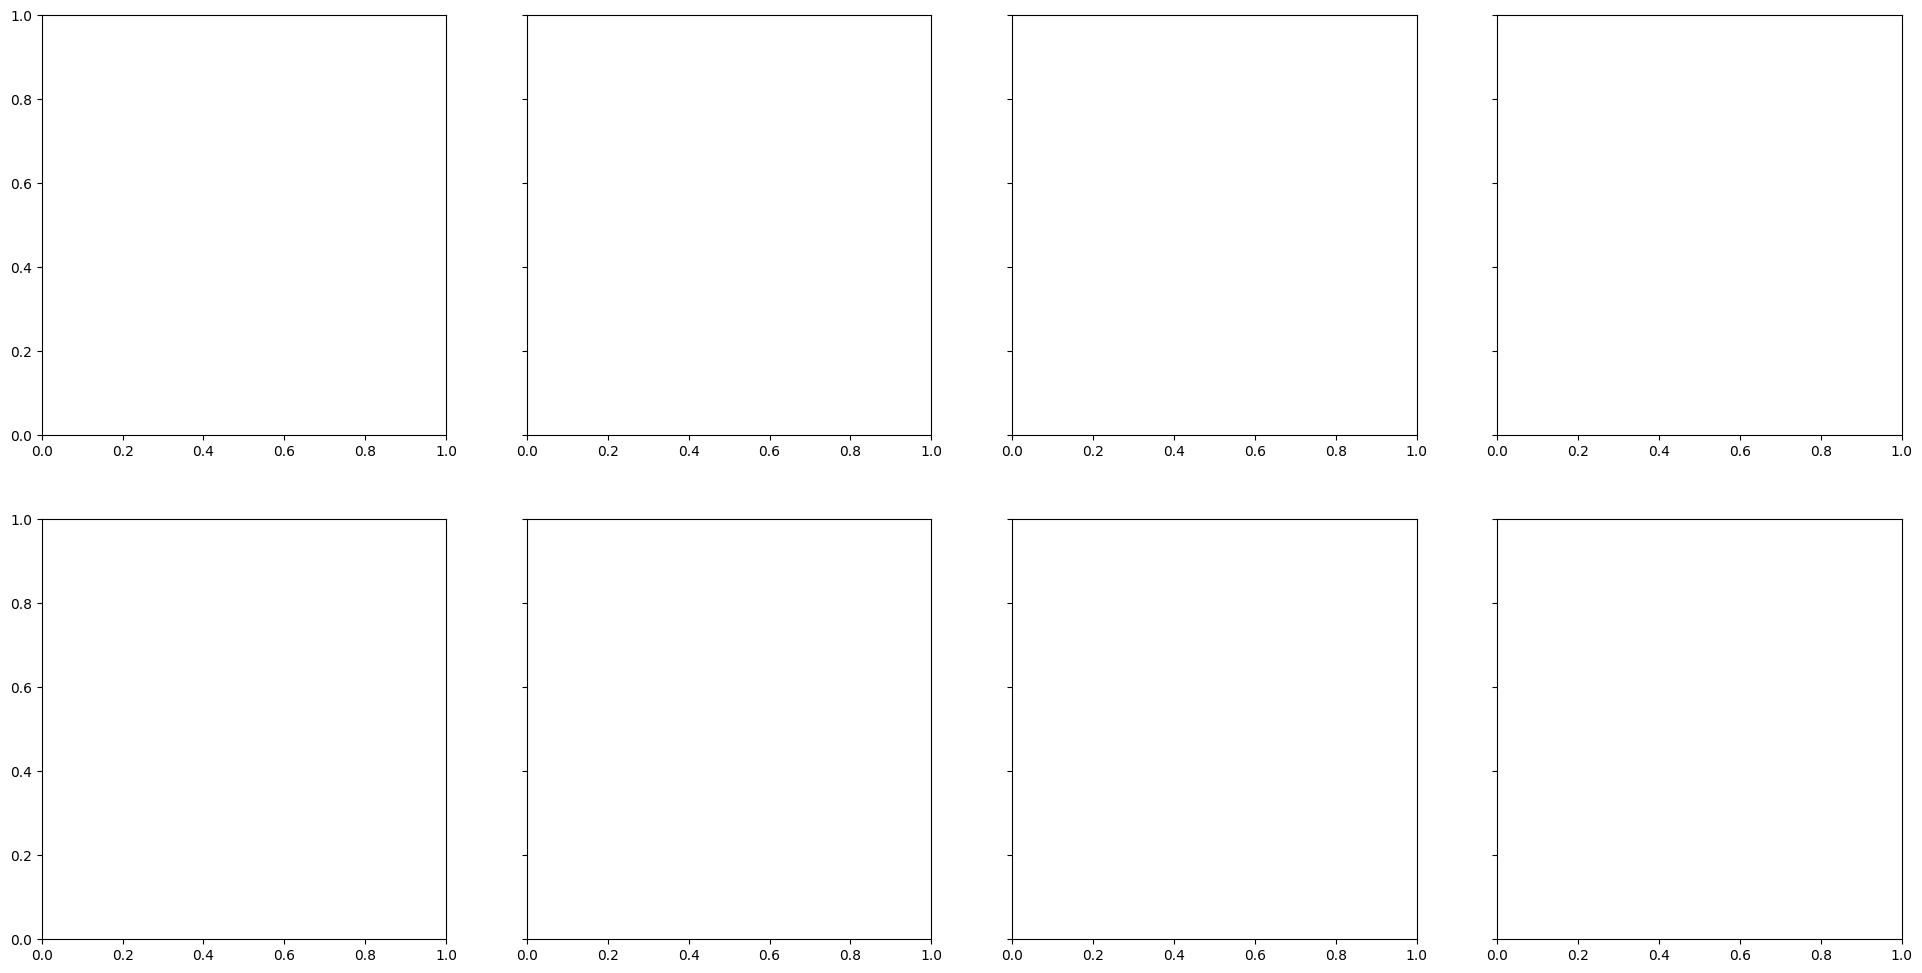

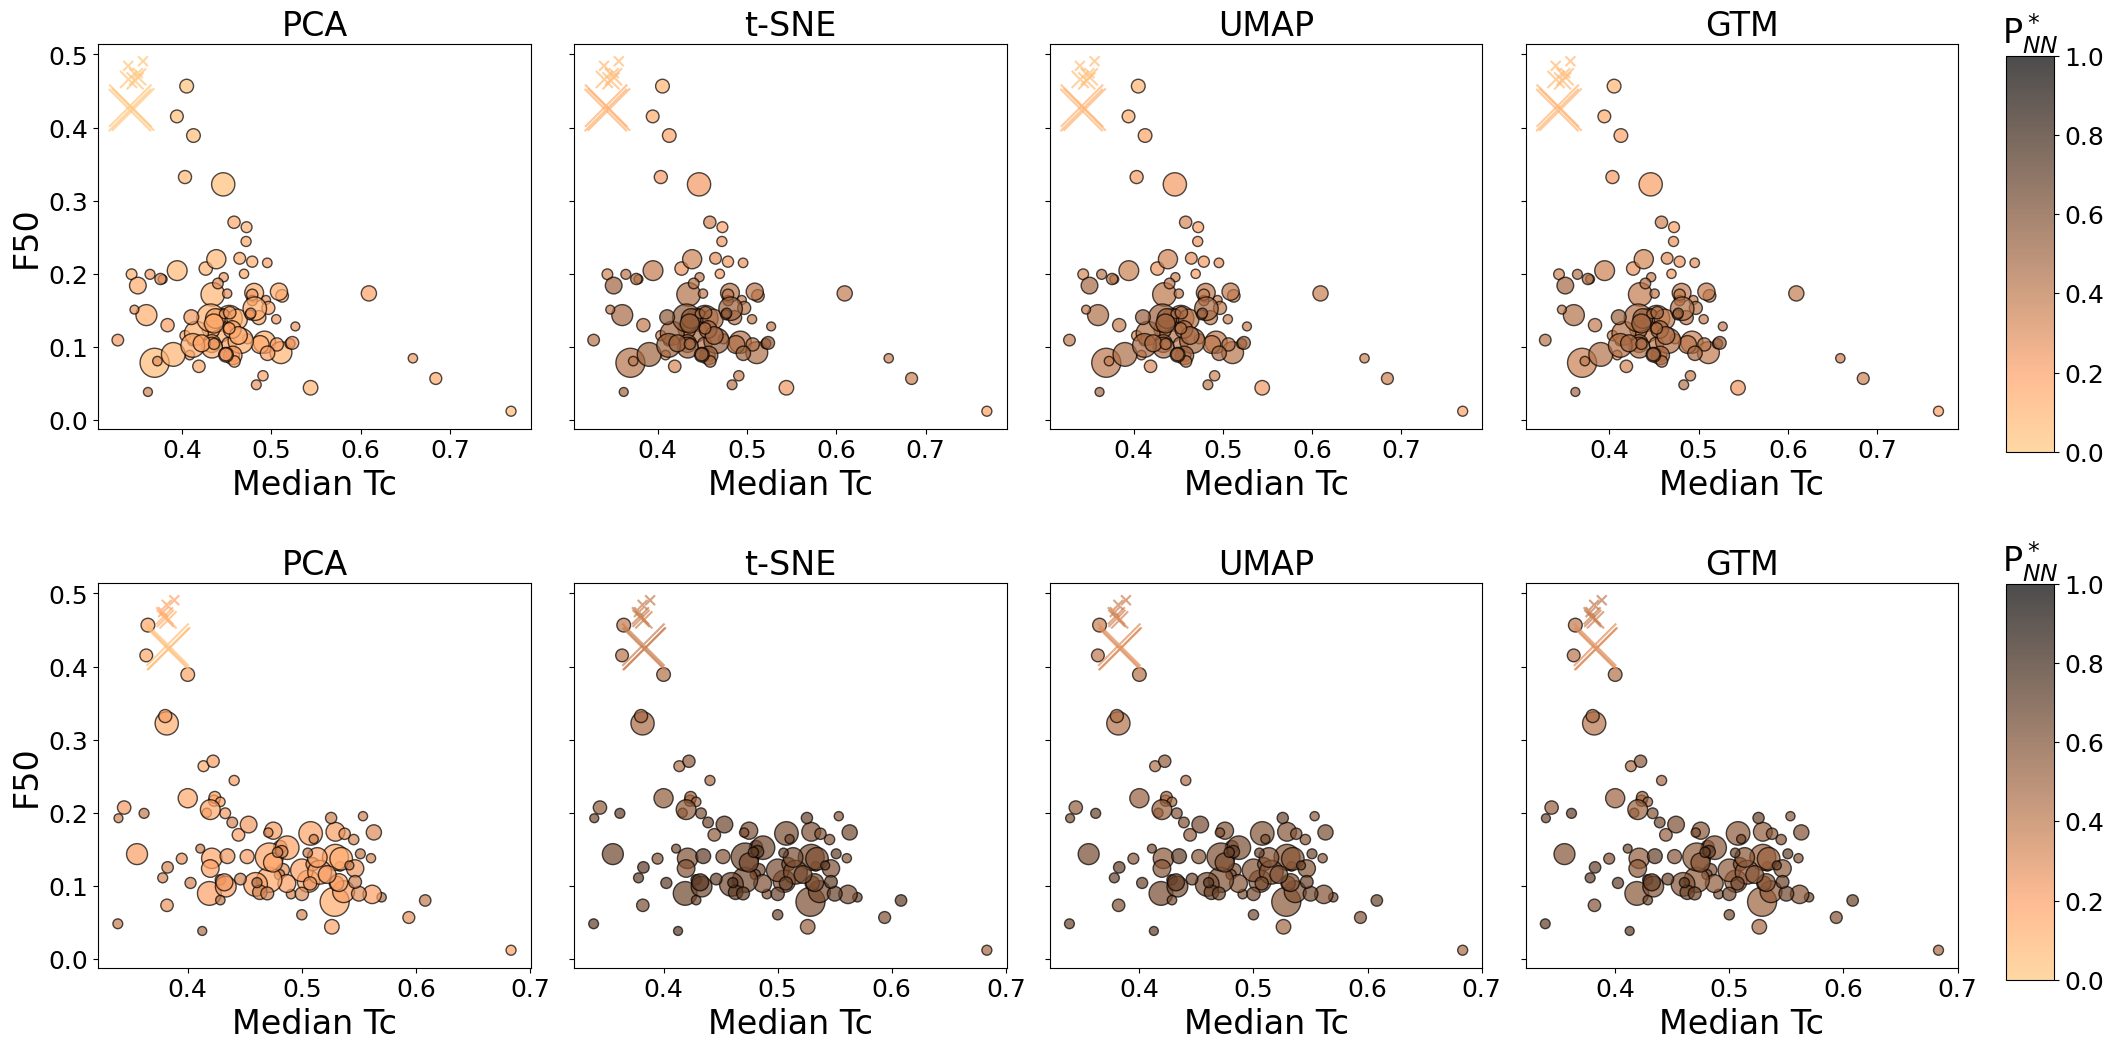

In [255]:
# Updating to incorporate separate nn_overlap_best columns for 'maccs_keys' as specified by the user

# Preparing the merged data based on the provided column structure with separate columns for each method-feature combination
merged_data = final_df[(final_df['Feature'] == 'mfp_r2_1024')][[
    'Median_mfp_r2_1024', 'Median_maccs_keys', 'Dataset', '# of data points', 'F50',
    'PCA_mfp_r2_1024_nn_overlap_best', 't-SNE_mfp_r2_1024_nn_overlap_best', 'UMAP_mfp_r2_1024_nn_overlap_best', 'GTM_mfp_r2_1024_nn_overlap_best',
    'PCA_maccs_nn_overlap_best', 't-SNE_maccs_nn_overlap_best', 'UMAP_maccs_nn_overlap_best',  'GTM_maccs_nn_overlap_best'
]]
merged_data = merged_data.sort_values('GTM_mfp_r2_1024_nn_overlap_best', ascending=True).reset_index()

# Defining sizes based on number of data points for scaling in the plot
sizes = merged_data['# of data points'] / 10
random_datasets = merged_data['Dataset'].str.contains("random")
sizes_random_datasets = merged_data['# of data points'][random_datasets] / 10

# Setting up the subplots for each method-feature combination in a 4x2 grid
fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharey=True)

# Column dictionary for method-feature nn_overlap_best
methods = {
    'PCA': ('PCA_mfp_r2_1024_nn_overlap_best', 'PCA_maccs_nn_overlap_best'),
    't-SNE': ('t-SNE_mfp_r2_1024_nn_overlap_best', 't-SNE_maccs_nn_overlap_best'),
    'UMAP': ('UMAP_mfp_r2_1024_nn_overlap_best', 'UMAP_maccs_nn_overlap_best'),
    'GTM': ('GTM_mfp_r2_1024_nn_overlap_best', 'GTM_maccs_nn_overlap_best')
}

# Define a larger tick font size

tick_font_size = 18

fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharey=True)

#cmap='copper_r'
cmap = plt.cm.get_cmap('copper_r')
#cmap = plt.cm.get_cmap('viridis')#, 10)


for col in merged_data.columns:
    if 'overlap' in col:
        merged_data[col] = merged_data[col] - 20 / merged_data['# of data points'] * 100


# Iterate over each method and create subplots with circle markers for all points

for i, (method_name, (nn_mfp, nn_maccs)) in enumerate(methods.items()):

    # Plot for mfp_r2_1024 (first row)

    sc1 = axes[0, i].scatter(
        merged_data['Median_mfp_r2_1024'][~random_datasets],
        merged_data['F50'][~random_datasets],
        s=sizes[~random_datasets],
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_mfp][~random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='o',  # Set marker to circle
        alpha=0.7
    )

    axes[0, i].scatter(
        merged_data['Median_mfp_r2_1024'][random_datasets],
        merged_data['F50'][random_datasets],
        s=sizes_random_datasets,
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_mfp][random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='x',  # Circle marker for random datasets as well
        alpha=0.7

    )

    axes[0, i].set_xlabel('Median Tc', fontsize=24)
    axes[0, i].set_title(f'{method_name}', fontsize=24)
    axes[0, i].tick_params(axis='both', which='major', labelsize=tick_font_size)
    axes[0, i].grid(False)



    # Plot for maccs_keys (second row)

    sc2 = axes[1, i].scatter(
        merged_data['Median_maccs_keys'][~random_datasets],
        merged_data['F50'][~random_datasets],
        s=sizes[~random_datasets],
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_maccs][~random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='o',  # Set marker to circle
        alpha=0.7

    )

    axes[1, i].scatter(
        merged_data['Median_maccs_keys'][random_datasets],
        merged_data['F50'][random_datasets],
        s=sizes_random_datasets,
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_maccs][random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='x',  # Circle marker for random datasets as well
        alpha=0.7

    )

    axes[1, i].set_xlabel('Median Tc', fontsize=24)
    axes[1, i].set_title(f'{method_name}', fontsize=24)
    axes[1, i].tick_params(axis='both', which='major', labelsize=tick_font_size)
    axes[1, i].grid(False)



# Set labels for F50 (y-axis) on the leftmost column only

axes[0, 0].set_ylabel('F50', fontsize=24)
axes[1, 0].set_ylabel('F50', fontsize=24)



# Move the color bar outside the grid layout
"""
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjusted position for colorbar
cbar = fig.colorbar(sc1, cax=cbar_ax)
cbar.ax.set_title(r'P$^*_{NN}$', fontsize=24)
cbar.ax.tick_params(labelsize=22)  # Set font size for color bar ticks
"""

# Set up separate color bars for each row

cbar_ax1 = fig.add_axes([0.92, 0.54, 0.02, 0.33])  # Position for the top row color bar

cbar1 = fig.colorbar(sc1, cax=cbar_ax1)

cbar1.ax.set_title(r'P$^*_{NN}$', fontsize=24)

cbar1.ax.tick_params(labelsize=tick_font_size)



cbar_ax2 = fig.add_axes([0.92, 0.1, 0.02, 0.33])  # Position for the bottom row color bar

cbar2 = fig.colorbar(sc2, cax=cbar_ax2)

cbar2.ax.set_title(r'P$^*_{NN}$', fontsize=24)

cbar2.ax.tick_params(labelsize=tick_font_size)


# Overall title and layout adjustments

#plt.suptitle('F50 as a function of PCA, UMAP, GTM overlays for mfp_r2_1024 and maccs_keys', fontsize=16)
plt.subplots_adjust(right=0.9, hspace=0.4, wspace=0.1)  # Increase space between rows
plt.savefig('../results/diversity/plot_upd.svg')
plt.show()


/tmp/ipykernel_479146/2042209429.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('copper_r', 10)
/tmp/ipykernel_479146/2042209429.py:57: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0, i].scatter(
/tmp/ipykernel_479146/2042209429.py:91: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[1, i].scatter(


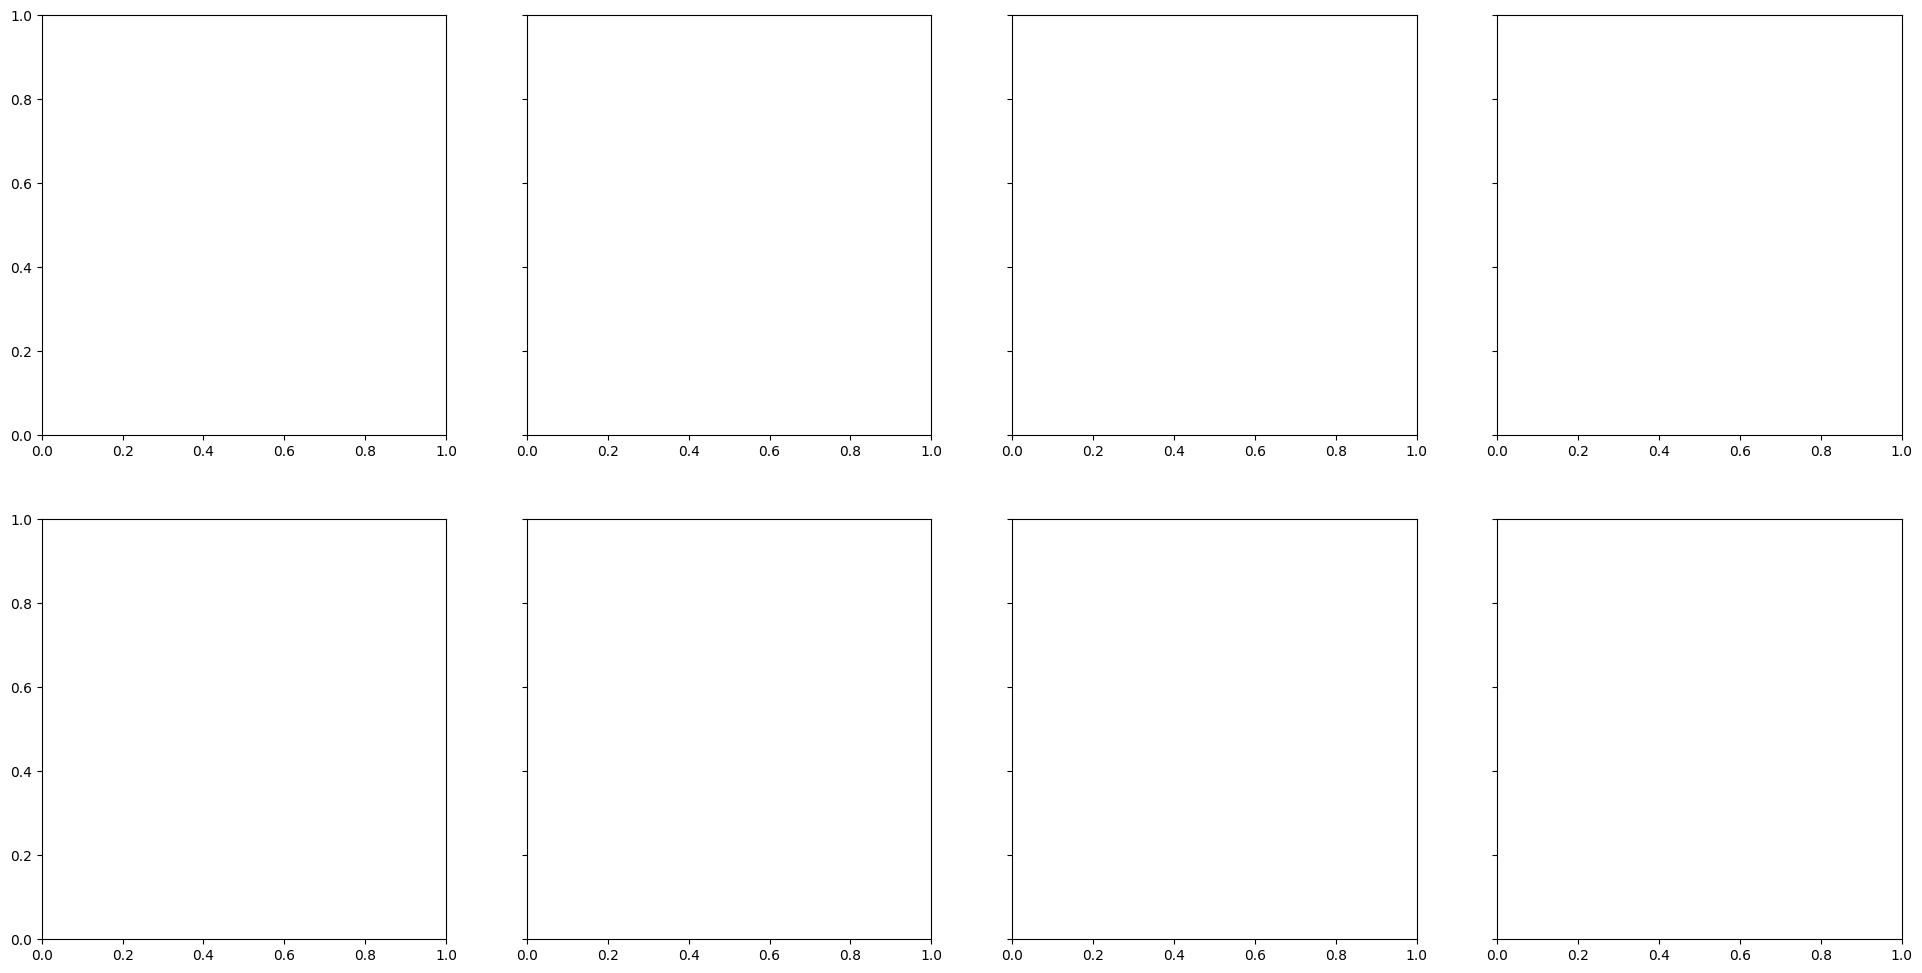

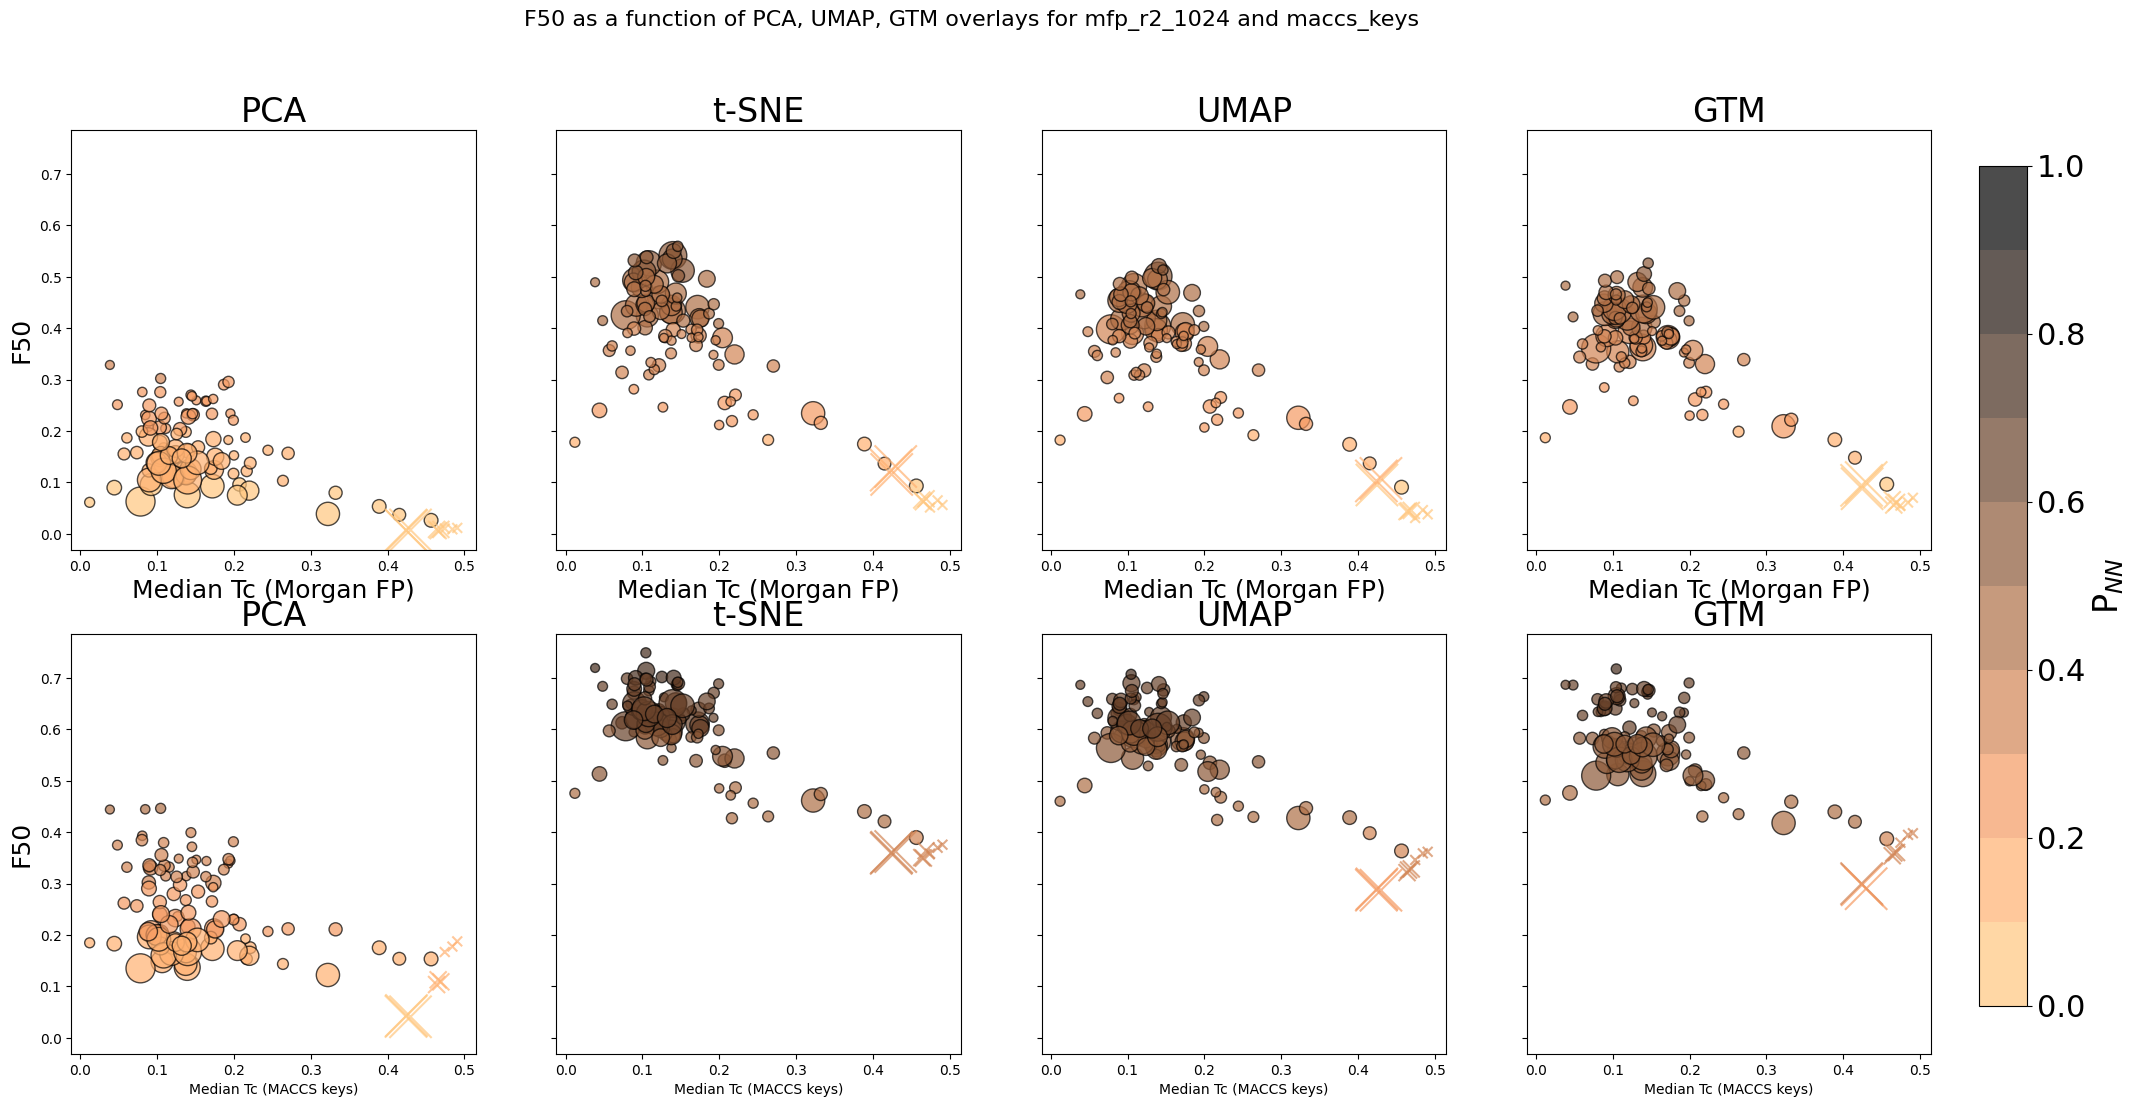

In [227]:
# Updating to incorporate separate nn_overlap_best columns for 'maccs_keys' as specified by the user

# Preparing the merged data based on the provided column structure with separate columns for each method-feature combination
merged_data = final_df[(final_df['Feature'] == 'mfp_r2_1024')][[
    'Median_mfp_r2_1024', 'Median_maccs_keys',  'SD_maccs_keys', 'SD_mfp_r2_1024', 'Dataset', '# of data points', 'F50',
    'PCA_mfp_r2_1024_nn_overlap_best', 't-SNE_mfp_r2_1024_nn_overlap_best', 'UMAP_mfp_r2_1024_nn_overlap_best', 'GTM_mfp_r2_1024_nn_overlap_best',
    'PCA_maccs_nn_overlap_best', 't-SNE_maccs_nn_overlap_best', 'UMAP_maccs_nn_overlap_best',  'GTM_maccs_nn_overlap_best'
]]
merged_data = merged_data.sort_values('GTM_mfp_r2_1024_nn_overlap_best', ascending=True).reset_index()

for col in merged_data.columns:
    if 'overlap' in col:
        merged_data[col] = merged_data[col] - 20 / merged_data['# of data points'] * 100

# Defining sizes based on number of data points for scaling in the plot
sizes = merged_data['# of data points'] / 10
random_datasets = merged_data['Dataset'].str.contains("random")
sizes_random_datasets = merged_data['# of data points'][random_datasets] / 10

# Setting up the subplots for each method-feature combination in a 4x2 grid
fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharey=True)

# Column dictionary for method-feature nn_overlap_best
methods = {
    'PCA': ('PCA_mfp_r2_1024_nn_overlap_best', 'PCA_maccs_nn_overlap_best'),
    't-SNE': ('t-SNE_mfp_r2_1024_nn_overlap_best', 't-SNE_maccs_nn_overlap_best'),
    'UMAP': ('UMAP_mfp_r2_1024_nn_overlap_best', 'UMAP_maccs_nn_overlap_best'),
    'GTM': ('GTM_mfp_r2_1024_nn_overlap_best', 'GTM_maccs_nn_overlap_best')
}



fig, axes = plt.subplots(2, 4, figsize=(24, 12), sharey=True)

#cmap='copper_r'
cmap = plt.cm.get_cmap('copper_r', 10)


# Iterate over each method and create subplots with circle markers for all points

for i, (method_name, (nn_mfp, nn_maccs)) in enumerate(methods.items()):

    # Plot for mfp_r2_1024 (first row)

    sc1 = axes[0, i].scatter(
        merged_data['F50'][~random_datasets],
        merged_data[nn_mfp][~random_datasets]/100,
        s=sizes[~random_datasets],
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_mfp][~random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='o',  # Set marker to circle
        alpha=0.7
    )

    axes[0, i].scatter(
        merged_data['F50'][random_datasets],
        merged_data[nn_mfp][random_datasets]/100,
        s=sizes_random_datasets,
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_mfp][random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='x',  # Circle marker for random datasets as well
        alpha=0.7

    )

    axes[0, i].set_xlabel('Median Tc (Morgan FP)', fontsize=18)
    axes[0, i].set_title(f'{method_name}', fontsize=24)
    axes[0, i].grid(False)



    # Plot for maccs_keys (second row)

    sc2 = axes[1, i].scatter(
        merged_data['F50'][~random_datasets],
        merged_data[nn_maccs][~random_datasets]/100,
        s=sizes[~random_datasets],
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_maccs][~random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='o',  # Set marker to circle
        alpha=0.7

    )

    axes[1, i].scatter(
        merged_data['F50'][random_datasets],
        merged_data[nn_maccs][random_datasets]/100,
        s=sizes_random_datasets,
        vmin=0, vmax=1,  # Fixed normalized color scale
        c=merged_data[nn_maccs][random_datasets]/100,
        cmap=cmap,
        edgecolor='black',
        marker='x',  # Circle marker for random datasets as well
        alpha=0.7

    )

    axes[1, i].set_xlabel('Median Tc (MACCS keys)')
    axes[1, i].set_title(f'{method_name}', fontsize=24)
    axes[1, i].grid(False)



# Set labels for F50 (y-axis) on the leftmost column only

axes[0, 0].set_ylabel('F50', fontsize=18)
axes[1, 0].set_ylabel('F50', fontsize=18)



# Move the color bar outside the grid layout

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjusted position for colorbar
cbar = fig.colorbar(sc1, cax=cbar_ax)
cbar.set_label(r'P$_{NN}$', fontsize=24)
cbar.ax.tick_params(labelsize=22)  # Set font size for color bar ticks

# Overall title and layout adjustments

plt.suptitle('F50 as a function of PCA, UMAP, GTM overlays for mfp_r2_1024 and maccs_keys', fontsize=16)
plt.subplots_adjust(right=0.9)  # Leave space for color bar on the right
plt.show()


In [195]:
final_df[final_df['Median_mfp_r2_1024'] > 0.7]

,Dataset,F50,Min_physchem,1st Qu._physchem,Median_physchem,Mean_physchem,3rd Qu._physchem,Max_physchem,SD_physchem,Min_mfp_r2_1024,...,GTM_mfp_r2_1024_AUC,GTM_mfp_r2_1024_kmax,GTM_mfp_r2_1024_Qlocal,GTM_mfp_r2_1024_Qglobal,GTM_mfp_r2_1024_trust_20,GTM_mfp_r2_1024_cont_20,Feature,# of data points,# non-constant descriptors,Fisher Separability ID
165,CHEMBL3973,0.012121,7.888609e-31,1006.659666,2899.695052,5930.888713,7336.735092,111988.18965,8235.614992,0.234982,...,0.602377,5.0,0.242933,0.605643,0.657737,0.744883,embed,516,16,1.822821
166,CHEMBL3973,0.012121,7.888609e-31,1006.659666,2899.695052,5930.888713,7336.735092,111988.18965,8235.614992,0.234982,...,0.602377,5.0,0.242933,0.605643,0.657737,0.744883,mfp_r2_1024,516,924,7.762371
167,CHEMBL3973,0.012121,7.888609e-31,1006.659666,2899.695052,5930.888713,7336.735092,111988.18965,8235.614992,0.234982,...,0.602377,5.0,0.242933,0.605643,0.657737,0.744883,maccs_keys,516,131,6.334209


In [220]:
path_2_dataset = Path('/home/aorlov/PycharmProjects/cdr_bench/data/data_upd/wide_range_upd230724/CHEMBL3973.h5')
df_features = read_features_hdf5_dataframe(path_2_dataset)


In [226]:
df_features['smi'].apply(lambda x: x.decode("utf-8")).to_csv('/home/aorlov/test.csv', index=False)

,index,Median_mfp_r2_1024,Median_maccs_keys,Dataset,# of data points,F50,PCA_mfp_r2_1024_nn_overlap_best,t-SNE_mfp_r2_1024_nn_overlap_best,UMAP_mfp_r2_1024_nn_overlap_best,GTM_mfp_r2_1024_nn_overlap_best,PCA_maccs_nn_overlap_best,t-SNE_maccs_nn_overlap_best,UMAP_maccs_nn_overlap_best,GTM_maccs_nn_overlap_best
0,16,0.340206,0.380282,chembl_random_1500_seed1309,1500,0.465852,0.610000,6.243333,4.450000,5.593333,11.280000,34.970000,32.643333,35.963333
1,25,0.350427,0.379747,chembl_random_1500_seed5968,1500,0.469373,0.846667,6.810000,4.540000,6.096667,10.883333,36.403333,32.863333,36.056667
2,7,0.347561,0.382716,chembl_random_1500_seed8176,1500,0.463821,0.843333,6.556667,4.313333,6.620000,10.353333,35.073333,32.143333,35.433333
3,19,0.345238,0.383562,chembl_random_9269_seed3665,9269,0.424637,0.607401,11.542777,9.495091,8.770094,4.331104,36.090733,28.971842,29.777214
4,22,0.350575,0.378378,chembl_random_500_seed493,500,0.474468,1.020000,5.110000,3.070000,5.480000,16.690000,35.830000,34.610000,37.960000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,118,0.449210,0.469697,CHEMBL3572,861,0.089783,24.982578,53.193961,48.635308,49.262485,33.583043,68.815331,65.011614,65.000000
99,232,0.523628,0.546667,CHEMBL1855,852,0.105541,23.397887,53.814554,49.865023,49.941315,35.580986,69.712441,67.505869,66.478873
100,82,0.410480,0.434783,CHEMBL275,1135,0.140741,22.762115,55.022026,52.114537,50.555066,24.348018,70.088106,68.863436,67.903084
101,181,0.361868,0.412698,CHEMBL2590,415,0.038462,32.855422,48.951807,46.602410,48.289157,44.421687,71.975904,68.686747,68.698795


In [ ]:
# Merge with chemdiv and network data based on relevant columns (assuming shared identifiers are present)
# Adding the Dataset column to make it easier to match or align based on dataset if needed
final_df = pd.concat([chemdiv_df, network_df, combined_metrics_df], axis=1)

In [ ]:
# Merge with chemdiv and network data based on relevant columns (assuming shared identifiers are present)
final_df = pd.concat([chemdiv_df, network_df, combined_metrics_df], axis=1)

In [64]:
final_df

,Network,Density,Degree Centrality Std Dev,Assortativity Coefficient,Network Entropy,Threshold,desc_type,Dataset,F50,Min_physchem,...,CHEMBL1293319_mfp_r2_1024_selected_metrics_UMAP_Qglobal,CHEMBL1293319_mfp_r2_1024_selected_metrics_UMAP_trust_20,CHEMBL1293319_mfp_r2_1024_selected_metrics_UMAP_cont_20,CHEMBL1293319_mfp_r2_1024_selected_metrics_GTM_nn_overlap_best,CHEMBL1293319_mfp_r2_1024_selected_metrics_GTM_AUC,CHEMBL1293319_mfp_r2_1024_selected_metrics_GTM_kmax,CHEMBL1293319_mfp_r2_1024_selected_metrics_GTM_Qlocal,CHEMBL1293319_mfp_r2_1024_selected_metrics_GTM_Qglobal,CHEMBL1293319_mfp_r2_1024_selected_metrics_GTM_trust_20,CHEMBL1293319_mfp_r2_1024_selected_metrics_GTM_cont_20
0,chembl_random_500_seed1526,0.147832,0.151942,0.168075,4.525084,0.5,mfp_r2_1024,chembl_random_500_seed1526,0.484407,2.094392e+00,...,0.524515,0.641991,0.77949,24.441939,0.535454,4.0,0.297233,0.536366,0.68777,0.628608
1,chembl_random_500_seed1526,0.038373,0.060516,0.177690,3.114570,0.6,mfp_r2_1024,chembl_random_9269_seed175,0.423946,7.888609e-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chembl_random_500_seed1526,0.004297,0.011138,0.249205,1.312934,0.7,mfp_r2_1024,chembl_random_1500_seed8176,0.463821,1.271226e-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chembl_random_500_seed1526,0.000072,0.000562,0.203540,0.128462,0.8,mfp_r2_1024,chembl_random_500_seed7955,0.490722,2.893186e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chembl_random_500_seed1526,0.000000,0.000000,NaN,0.000000,0.9,mfp_r2_1024,chembl_random_9269_seed251,0.429867,7.888609e-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL204,0.139722,1.232595e-32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL3356,0.207207,1.232595e-32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL4860,0.173228,4.437343e-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL2998,0.056872,1.972152e-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [258]:
network_df_merge = pd.merge(network_df, merged_data, left_on='Network', right_on='Dataset', how='left')

In [285]:
columns_check = ['Density', 'Degree Centrality Std Dev',
       'Assortativity Coefficient', 'Network Entropy']
sel_cols = [        'Median_mfp_r2_1024', 'Median_maccs_keys',
       '# of data points', 'F50', 'PCA_mfp_r2_1024_nn_overlap_best',
       't-SNE_mfp_r2_1024_nn_overlap_best', 'UMAP_mfp_r2_1024_nn_overlap_best',
       'GTM_mfp_r2_1024_nn_overlap_best', 'PCA_maccs_nn_overlap_best',
       't-SNE_maccs_nn_overlap_best', 'UMAP_maccs_nn_overlap_best',
       'GTM_maccs_nn_overlap_best']
for ths in [0.5, 0.6, 0.7, 0.8, 0.9]:
    for desc_type in ['mfp_r2_1024', 'maccs_keys']:
        network_df_merge_temp = network_df_merge[(network_df_merge['Threshold'] == ths)&(network_df_merge['desc_type'] == desc_type)]
        if desc_type == 'maccs_keys':
            desc_type = 'maccs'
        sel_col = [col for col in sel_cols if desc_type in col]
        fin_col = columns_check + sel_col
        print(ths, desc_type)
        print('*'*40)
        print(network_df_merge_temp[fin_col].corr(method='spearman').loc[columns_check, sel_col])

0.5 mfp_r2_1024
****************************************
                           Median_mfp_r2_1024  \
Density                              0.965306   
Degree Centrality Std Dev            0.676130   
Assortativity Coefficient           -0.266639   
Network Entropy                     -0.027237   

                           PCA_mfp_r2_1024_nn_overlap_best  \
Density                                           0.381134   
Degree Centrality Std Dev                         0.033860   
Assortativity Coefficient                         0.497573   
Network Entropy                                  -0.445548   

                           t-SNE_mfp_r2_1024_nn_overlap_best  \
Density                                             0.173890   
Degree Centrality Std Dev                           0.080350   
Assortativity Coefficient                           0.470577   
Network Entropy                                     0.406207   

                           UMAP_mfp_r2_1024_nn_overlap_best  \
De